In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20_mod = gp.read_file("./raw-from-source/VEST/mod_vest/mod_vest.shp")

In [3]:
vest_fl_20_clean = gp.read_file("/Users/peterhorton/Documents/RDH/erj/erj-fl/2020/primary/raw-from-source/VEST/fl_2020_clean/fl_2020_clean.shp")
vest_fl_20_clean = vest_fl_20_clean.to_crs(vest_fl_20_mod.crs)
vest_fl_20_clean = vest_fl_20_clean[~vest_fl_20_clean["pct_std"].isin(["CLL0416","CLL0414"])]
vest_fl_20_mod_new = vest_fl_20_mod[vest_fl_20_mod["pct_std"].isin(["CLL0416","CLL0414"])]
combined_vest = gp.GeoDataFrame(pd.concat([vest_fl_20_clean, vest_fl_20_mod_new]), crs = vest_fl_20_mod.crs)
combined_vest.to_file("./raw-from-source/VEST/mod_vest_clean/mod_vest_clean.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [4]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/mod_vest_clean/mod_vest_clean.shp")

## Load the Presidential Preference Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/presidential_preference/")

In [6]:
#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store" and ".zip" not in i:
        ref = "./raw-from-source/Election_Results/presidential_preference/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
    
#All the files have 19 columns, so they should be good to combine

In [7]:
li = []
for i in all_files:
    if i !=".DS_Store" and ".zip" not in i and i != 'PAL_PctResults20200317.txt':
        ref = "./raw-from-source/Election_Results/presidential_preference/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)

## Clean up the Field Names

https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [8]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

frame.rename(columns = col_rename_dict, inplace = True)

## Filter Down to Relevant Races and Clean up Data

In [9]:
# Standardize the names
race_name_change_dict = {'U.S. President' : 'President of the United States'}

frame['Contest Name'] = frame['Contest Name'].map(race_name_change_dict).fillna(frame['Contest Name'])

races_list = ['President of the United States']

#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2865749665.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2865749665.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-

## Clean up the "pct_std" column

Note: Sometimes the precinct polling location also contains the 3-digit county code, this deals with that

In [10]:
name_update_dict = {}
for i in list(filtered_frame["pct_std"]):
    if (i[0:3] == i[3:6]):
        name_update_dict[i] = i[3:]
        
filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/1293977247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])


## Prepare the Data for Pivoting

In [11]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/3650888500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/3650888500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)
/var/folders/1t/0q4

In [12]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())
    
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

[ 775    0 1081 ... 3369 1462 1070]
[   0  389  427 ... 1459 2444 2245]
[0]


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/4115128933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)


## Pivot the Data and Clean the Columns

In [13]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

pivoted_2020 = pivoted_2020.fillna(0)

## Load Alternate Data for Madison and Duval County

For whatever reason, the data the state has for Madison and Duval County seems incomplete, use the county data instead

In [14]:
# Take a look at what the source (unpivoted) Duval data is
duv = pd.read_csv("./raw-from-source/Election_Results/presidential_preference/DUV_PctResults20200317.txt",sep="\t",engine='python',index_col=None, header=None)


In [15]:
#199 precincts DUV precincts in VEST's file
print(len(vest_fl_20[vest_fl_20["county"]=="DUV"]["precinct"].unique()))
print("")

#Only 126 unique precinct polling locations in the state's file
print(len(duv[6].value_counts(dropna = False)))
print("")

#For the others, there isn't enough information in the unique precinct identifier to distinguish among them
print(duv[duv[6].isna()][5].value_counts(dropna=False))

199

126

100    216
110    216
120    216
130    216
140    216
101    168
111    168
131    144
141    120
121     96
Name: 5, dtype: int64


In [16]:
counties_alt_source = ['DUV', 'MAD']
holder = []
for county in counties_alt_source:
    county_temp = pd.read_csv("./raw-from-source/Election_Results/pp_alt/"+county+".csv")
    county_temp['County Code (Three-character abbreviation)'] = county
    holder.append(county_temp)
alt_sources = pd.concat(holder)

In [17]:
alt_sources.reset_index(drop = True, inplace = True)

In [18]:
county_names = {"DUV":"Duval",
"MAD":"Madison"}

contest_changes = {
    'PRESIDENT REP':'REPUBLICAN PRESIDENTIAL CANDIDATES',
    'PRESIDENT DEM':'DEMOCRATIC PRESIDENTIAL CANDIDATES'
}

candidate_changes = {
    'Julián Castro':'Julian Castro'
}

In [19]:
alt_sources['County Name'] = alt_sources['County Code (Three-character abbreviation)'].map(county_names)
alt_sources["Contest"] = alt_sources["Contest"].map(contest_changes).fillna(alt_sources["Contest"])
alt_sources["Candidate Issue"] = alt_sources["Candidate Issue"].map(candidate_changes).fillna(alt_sources["Candidate Issue"])

In [20]:
alt_sources = alt_sources[alt_sources["Contest"].str.contains("PRESIDENTIAL")]
alt_sources["Precinct Name"] = alt_sources["Precinct Name"].astype(str).str.zfill(4)
alt_sources['pct_std'] = alt_sources['County Code (Three-character abbreviation)'] + alt_sources["Precinct Name"]
alt_sources_pivoted = pd.pivot_table(alt_sources, values=["Total Votes"], index = ["pct_std",'County Code (Three-character abbreviation)', 'County Name'], columns=["Candidate Issue"],aggfunc=sum)
alt_sources_pivoted.columns = alt_sources_pivoted.columns.droplevel()
alt_sources_pivoted.reset_index(inplace = True, drop = False)

In [21]:
pivoted_columns  = [i for i in pivoted_2020.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']]

alt_columns = [i for i in alt_sources_pivoted.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)',
 'County Name']]

In [22]:
alt_col_rename_dict = dict(zip(alt_columns, pivoted_columns))

alt_sources_pivoted.rename(columns = alt_col_rename_dict, inplace = True)

pivoted_2020 = pivoted_2020[~pivoted_2020["County Name"].isin(['Madison', 'Duval'])]

pivoted_2020 = pd.concat([pivoted_2020, alt_sources_pivoted])

pivoted_2020.reset_index(drop=True, inplace = True)

## Rename Columns

In [23]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

In [24]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [25]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    else:
        print(contest)
        return ValueError

In [26]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [27]:
races_list = ['President of the United States']

In [28]:
contest_name_change_dict = {}

duplicate_value_list = []
for contest in pivoted_2020.columns:
    if contest not in keep_names:
        # Add in a condition about the 20
        if "President" in contest:
            value = "P20"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value 
        else:
            value = "P"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value

if len(duplicate_value_list) > 0:
    print("DUPLICATE VALUES")
    for val in [(k,v) for k, v in contest_name_change_dict.items() if v in duplicate_value_list]:
        print(val)

In [29]:
contest_name_change_dict

{'President of the United States-Amy Klobuchar-PARTY:DEM': 'P20PREDKLO',
 'President of the United States-Andrew Yang-PARTY:DEM': 'P20PREDYAN',
 'President of the United States-Bernie Sanders-PARTY:DEM': 'P20PREDSAN',
 'President of the United States-Bill Weld-PARTY:REP': 'P20PRERWEL',
 'President of the United States-Cory Booker-PARTY:DEM': 'P20PREDBOO',
 'President of the United States-Deval Patrick-PARTY:DEM': 'P20PREDPAT',
 'President of the United States-Donald J. Trump-PARTY:REP': 'P20PRERTRU',
 'President of the United States-Elizabeth Warren-PARTY:DEM': 'P20PREDWAR',
 'President of the United States-Joe Biden-PARTY:DEM': 'P20PREDBID',
 'President of the United States-Joe Sestak-PARTY:DEM': 'P20PREDSES',
 'President of the United States-Joe Walsh-PARTY:REP': 'P20PRERWAL',
 'President of the United States-John Delaney-PARTY:DEM': 'P20PREDDEL',
 'President of the United States-Julian Castro-PARTY:DEM': 'P20PREDCAS',
 'President of the United States-Marianne Williamson-PARTY:DEM': 

In [30]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [31]:
df = pd.DataFrame([(v, k.split("-")[1]) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.sort_values('Candidate', inplace = True)
df.to_csv('./st_cand_dict.csv', sep=',')

simple_cand_name_change_dict = dict(zip(df["Column"], df["Candidate"]))

### Precinct-by-Precinct Check

In [32]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020["pct_std"].value_counts(dropna=False))

ALA0001    1
DAD0122    1
DAD0131    1
DAD0130    1
DAD0129    1
          ..
ORA0536    1
ORA0535    1
ORA0534    1
ORA0533    1
CLL0416    1
Name: pct_std, Length: 6011, dtype: int64
ALA001                           1
PAL2120                          1
PAL2134                          1
PAL2132                          1
PAL2130                          1
                                ..
ESC0111                          1
ESC0110                          1
ESC0108                          1
ESC0107                          1
MAD9 Recycling Center, Lamont    1
Name: pct_std, Length: 6007, dtype: int64


In [33]:
data_columns_full = [i for i in pivoted_2020.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

We discovered that the totals are slightly different in Seminole County and manually added votes to correct that

In [34]:
sem_diff = pd.DataFrame(0, index=np.arange(1), columns = pivoted_2020.columns)
sem_diff["pct_std"] = "SEMDIFF"
sem_diff["County Code (Three-character abbreviation)"] = "SEM"
sem_diff["County Name"] = "Seminole"

sem_diff["P20PREDBID"] = 3
sem_diff["P20PREDBLO"] = -2
sem_diff["P20PREDSAN"] = 5
sem_diff["P20PRERTRU"] = -1

pivoted_2020 = pd.concat([pivoted_2020, sem_diff], ignore_index = True, axis = 0)

In [35]:
to_allocate = [
 'PAL8001',
 'PAL8002',
 'SEM0081',
 'SEM0082',
 'SEM0083',
 'SEM0084',
 'SEM0085',
 'SEM0086',
 'SEM0087',
 'SEM0088',
 'SEM0089',
'BRE0999','DAD0100','BROZ073','CLL0450','HIL0999','LEO9000','PIN0512',"SEMDIFF"]

In [36]:
allocating_votes = pivoted_2020[pivoted_2020["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020[~pivoted_2020["pct_std"].isin(to_allocate)]

In [37]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [38]:
#Perform the allocation
pivoted_2020 = allocate_absentee(receiving_votes,allocating_votes,data_columns_full,'County Name',allocating_to_all_empty_precs=False)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2056752905.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2056752905.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2056752905.py:109: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future v

## Collier:

Precinct 416 now part of precinct 414 (https://www.colliervotes.gov/Research-Data/News-Releases-Public-Notices/ArtMID/26390/ArticleID/3158/NEWS-RELEASE-Collier-County-Supervisor-of-Elections-Office-Announces-Precinct-and-Polling-Location-Changes), should I go and make a shapefile change?

## Hernado:
https://www.hernandovotes.gov/Portals/Hernando/202092_Official%20Election%20Statement%20of%20Votes%20Cast.pdf?ver=vZ-CEZIqDJzSD3k7Mdk6Ag%3d%3dOfficial

DAYSPRING PRESB CH seems to now be PROVIDENCE CH
FAITH EVANL FREE CH seems to now be GATEWAY BIBLE CH

## Sarasota:

Looks like mistake in how precinct 41 was named, should be 413 and votes match those on the Sarasota elections website https://www.sarasotavotes.gov/Election-Information/Election-Results

## Washington:

The precinct labeling is slightly off, fixed it using this link: https://www.wcsoe.org/m/Voter-Information/Precinct-Finder

## Seminole:

Precinct #22 is mislabeled, should be Wekiva

## Osceola:

Precinct 62 should be 411 from looking at the 6th column

I think precinct 452 should be merged back with precinct 450 in VEST's shapefile

## Ind:

Precinct numberings are off, cleaned above

## BRE:

I think precinct 442 just doesn't have votes, no news about it changing and very few votes in the general election

In [39]:
## Merge Osceola precinct 452 with Osceola precinct 450

In [40]:
vest_fl_20.loc[vest_fl_20["pct_std"]=="OSC0450"]

,pct_std,county,precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREODEL,G20PRESLAR,G20PREGHAW,G20PRECBLA,G20PREOWRI,COUNTYFP,geometry
5974,OSC0450,OSC,450,386,662,6,5,2,0,0,1,097,"MULTIPOLYGON Z (((-81.35691 28.26755 0.00000, ..."


<AxesSubplot: >

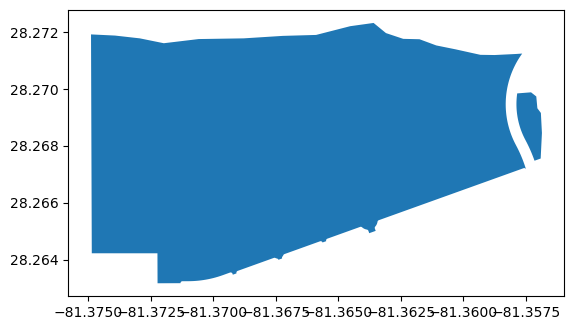

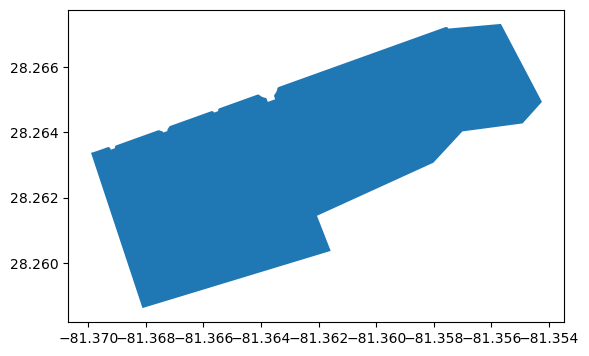

In [41]:
vest_fl_20[vest_fl_20["pct_std"] == "OSC0450"].plot()

vest_fl_20[vest_fl_20["pct_std"] == "OSC0452"].plot()

In [42]:
to_combine = vest_fl_20[vest_fl_20["pct_std"].isin(["OSC0450", "OSC0452"])]
vest_fl_20 = vest_fl_20[~vest_fl_20["pct_std"].isin(["OSC0450", "OSC0452"])]

In [43]:
combined_prec = to_combine.dissolve('county')

In [44]:
combined_prec.reset_index(inplace = True, drop = False)

In [45]:
combined_prec = combined_prec[list(vest_fl_20.columns)]

In [46]:
vest_fl_20 = pd.concat([vest_fl_20, combined_prec])
vest_fl_20.reset_index(inplace = True, drop = False)

<AxesSubplot: >

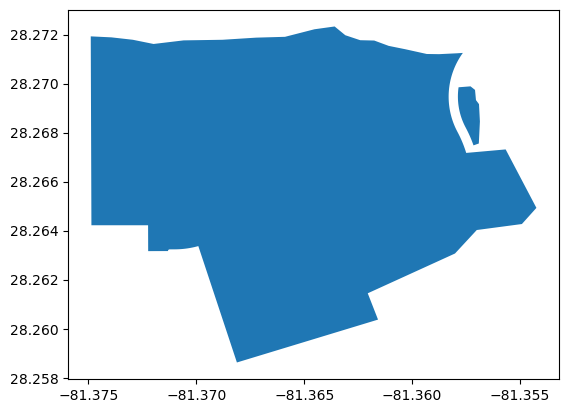

In [47]:
vest_fl_20[vest_fl_20["pct_std"] == "OSC0450"].plot()

In [48]:
election_vest_id_changes = pd.read_csv("./raw-from-source/st_id_changes_dict.csv")
election_vest_id_changes_dict = dict(zip(election_vest_id_changes["primary_ID"],election_vest_id_changes["vest_ID"]))

pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/485168292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])


In [49]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
print(join_attempt_one["_merge"].value_counts())
join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./vest_only.csv")
join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./results_only.csv")

both          5989
left_only       21
right_only       0
Name: _merge, dtype: int64


## Add a COUNTYFP column

In [50]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

join_attempt_one["COUNTYFP"] = join_attempt_one["County Name"].map(fl_fips_dict).fillna(join_attempt_one["County Name"])

join_attempt_one["County Name"] = np.where(join_attempt_one["County Name"].isna(), join_attempt_one["county"], join_attempt_one["County Name"])

fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
  'OSC':'097'
}

join_attempt_one["COUNTYFP"] = join_attempt_one["County Name"].map(fl_fips_dict_2).fillna(join_attempt_one["COUNTYFP"])

join_attempt_one["COUNTYFP"].unique()

array(['001', '005', '007', '011', '013', '015', '017', '019', '023',
       '027', '029', '035', '037', '039', '041', '043', '049', '051',
       '053', '055', '057', '059', '063', '065', '067', '071', '075',
       '077', '079', '081', '089', '091', '093', '095', '103', '105',
       '107', '113', '115', '117', '111', '119', '121', '123', '125',
       '129', '131', '133', '003', '009', '021', '031', '033', '045',
       '047', '061', '069', '073', '083', '085', '086', '087', '099',
       '109', '127', '101', '097'], dtype=object)

In [51]:
join_attempt_one.drop([i for i in join_attempt_one.columns if "_x" in i], axis = 1, inplace = True)

join_attempt_one.columns = [i.replace("_y","") for i in join_attempt_one.columns]

join_attempt_one["UNIQUE_ID"] = join_attempt_one["pct_std"]

In [52]:
state_data_columns = ['P20PREDKLO', 'P20PREDYAN', 'P20PREDSAN', 'P20PRERWEL',
       'P20PREDBOO', 'P20PREDPAT', 'P20PRERTRU', 'P20PREDWAR', 'P20PREDBID',
       'P20PREDSES', 'P20PRERWAL', 'P20PREDDEL', 'P20PREDCAS', 'P20PREDWIL',
       'P20PREDBEN', 'P20PREDBLO', 'P20PREDBUT', 'P20PRERFUE', 'P20PREDSTE',
       'P20PREDGAB']

In [53]:
join_attempt_one = join_attempt_one[["UNIQUE_ID","COUNTYFP","pct_std",'county','precinct']+state_data_columns+["geometry"]]

In [54]:
for val in state_data_columns:
    join_attempt_one[val] = join_attempt_one[val].fillna(0)
    join_attempt_one[val] = join_attempt_one[val].astype(int)

## Election Totals Checks

In [55]:
state_data_columns.sort()

In [56]:
tot_sum = 0
for val in state_data_columns:
    tot_sum += sum(join_attempt_one[val])
    print(val, sum(join_attempt_one[val]))

P20PREDBEN 4244
P20PREDBID 1077375
P20PREDBLO 146544
P20PREDBOO 1507
P20PREDBUT 39886
P20PREDCAS 1036
P20PREDDEL 1583
P20PREDGAB 8712
P20PREDKLO 17276
P20PREDPAT 661
P20PREDSAN 397311
P20PREDSES 664
P20PREDSTE 2510
P20PREDWAR 32875
P20PREDWIL 1744
P20PREDYAN 5286
P20PRERFUE 12172
P20PRERTRU 1162984
P20PRERWAL 25464
P20PRERWEL 39319


Correct candidates: Weld, Walsh, Weld, Bennet, Booker, Buttigieg, Castro, Delaney, Gabbard, Klobuchar, Patrick, Sestak, Steyer, Warren, Williamson, Yang

Incorrect candidates: Trump, Biden, Bloomberg, Sanders
- Trump
- Biden
- Bloomberg
- Sanders

P20PREDKLO 17276
P20PREDYAN 5286
P20PREDSAN 397306
P20PRERWEL 39319
P20PREDBOO 1507
P20PREDPAT 661
P20PRERTRU 1162985
P20PREDWAR 32875
P20PREDBID 1077372
P20PREDSES 664
P20PRERWAL 25464
P20PREDDEL 1583
P20PREDCAS 1036
P20PREDWIL 1744
P20PREDBEN 4244
P20PREDBLO 146546
P20PREDBUT 39886
P20PRERFUE 12172
P20PREDSTE 2510
P20PREDGAB 8712

In [57]:
def county_totals_check(source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        if race[6:] in ["RTRU", "DBID", "DBLO", "DSAN"]:
            print(race)
            diff = source_df.groupby([county_col]).sum()[race]
            for val in diff.index.values.tolist():
                if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
                    print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
                    
county_totals_check(join_attempt_one,state_data_columns,"county",True)

***Countywide Totals Check***

P20PREDBID
	ALA: 19077 votes
	BAK: 593 votes
	BAY: 5184 votes
	BRA: 952 votes
	BRE: 33012 votes
	BRO: 122637 votes
	CAL: 389 votes
	CHA: 9080 votes
	CIT: 6951 votes
	CLA: 6714 votes
	CLL: 15573 votes
	CLM: 2292 votes
	DAD: 94793 votes
	DES: 863 votes
	DIX: 338 votes
	DUV: 56227 votes
	ESC: 17036 votes
	FLA: 7520 votes
	FRA: 764 votes
	GAD: 6446 votes
	GIL: 415 votes
	GLA: 383 votes
	GUL: 665 votes
	HAM: 678 votes
	HAR: 493 votes
	HEN: 953 votes
	HER: 8240 votes
	HIG: 3569 votes
	HIL: 67791 votes
	HOL: 263 votes
	IND: 9079 votes
	JAC: 2437 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify nu

	JEF: 1551 votes
	LAF: 173 votes
	LAK: 18574 votes
	LEE: 28192 votes
	LEO: 28946 votes
	LEV: 1497 votes
	LIB: 306 votes
	MAD: 1467 votes
	MAN: 21036 votes
	MON: 5206 votes
	MRN: 18372 votes
	MRT: 8166 votes
	NAS: 3816 votes
	OKA: 5572 votes
	OKE: 1034 votes
	ORA: 64901 votes
	OSC: 13508 votes
	PAL: 104788 votes
	PAS: 22206 votes
	PIN: 61288 votes
	POL: 27129 votes
	PUT: 2764 votes
	SAN: 4776 votes
	SAR: 31605 votes
	SEM: 23579 votes
	STJ: 14331 votes
	STL: 18800 votes
	SUM: 9374 votes
	SUW: 1291 votes
	TAY: 856 votes
	UNI: 308 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	VOL: 26103 votes
	WAK: 1741 votes
	WAL: 1939 votes
	WAS: 773 votes
P20PREDBLO
	ALA: 841 votes
	BAK: 50 votes
	BAY: 265 votes
	BRA: 153 votes
	BRE: 4412 votes
	BRO: 14608 votes
	CAL: 34 votes
	CHA: 1804 votes
	CIT: 1292 votes
	CLA: 648 votes
	CLL: 2525 votes
	CLM: 255 votes
	DAD: 17330 votes
	DES: 85 votes
	DIX: 40 votes
	DUV: 4453 votes
	ESC: 1200 votes
	FLA: 881 votes
	FRA: 50 votes
	GAD: 382 votes
	GIL: 31 votes
	GLA: 37 votes
	GUL: 33 votes
	HAM: 37 votes
	HAR: 35 votes
	HEN: 102 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	HER: 1923 votes
	HIG: 649 votes
	HIL: 11665 votes
	HOL: 30 votes
	IND: 1330 votes
	JAC: 145 votes
	JEF: 98 votes
	LAF: 24 votes
	LAK: 1284 votes
	LEE: 6544 votes
	LEO: 1671 votes
	LEV: 159 votes
	LIB: 17 votes
	MAD: 109 votes
	MAN: 3493 votes
	MON: 674 votes
	MRN: 2426 votes
	MRT: 1322 votes
	NAS: 436 votes
	OKA: 321 votes
	OKE: 126 votes
	ORA: 5623 votes
	OSC: 3464 votes
	PAL: 14236 votes
	PAS: 3799 votes
	PIN: 10971 votes
	POL: 3861 votes
	PUT: 244 votes
	SAN: 372 votes
	SAR: 5524 votes
	SEM: 1973 votes
	STJ: 1308 votes
	STL: 2286 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	SUM: 1616 votes
	SUW: 145 votes
	TAY: 154 votes
	UNI: 22 votes
	VOL: 4699 votes
	WAK: 91 votes
	WAL: 98 votes
	WAS: 29 votes
P20PREDSAN
	ALA: 14903 votes
	BAK: 150 votes
	BAY: 1776 votes
	BRA: 250 votes
	BRE: 13190 votes
	BRO: 35981 votes
	CAL: 107 votes
	CHA: 2565 votes
	CIT: 2132 votes
	CLA: 2789 votes
	CLL: 3753 votes
	CLM: 655 votes
	DAD: 34829 votes
	DES: 242 votes
	DIX: 104 votes
	DUV: 19930 votes
	ESC: 5450 votes
	FLA: 1917 votes
	FRA: 214 votes
	GAD: 875 votes
	GIL: 149 votes
	GLA: 99 votes
	GUL: 125 votes
	HAM: 123 votes
	HAR: 142 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	HEN: 286 votes
	HER: 3199 votes
	HIG: 931 votes
	HIL: 32734 votes
	HOL: 116 votes
	IND: 2326 votes
	JAC: 462 votes
	JEF: 276 votes
	LAF: 58 votes
	LAK: 5591 votes
	LEE: 9769 votes
	LEO: 13656 votes
	LEV: 516 votes
	LIB: 68 votes
	MAD: 234 votes
	MAN: 6430 votes
	MON: 1991 votes
	MRN: 4632 votes
	MRT: 2364 votes
	NAS: 1073 votes
	OKA: 2434 votes
	OKE: 274 votes
	ORA: 36720 votes
	OSC: 7697 votes
	PAL: 23995 votes
	PAS: 9752 votes
	PIN: 27972 votes
	POL: 10084 votes
	PUT: 868 votes
	SAN: 2173 votes
	SAR: 9548 votes
	SEM: 13166 votes
	STJ: 5240 votes
	STL: 5092 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	SUM: 1231 votes
	SUW: 382 votes
	TAY: 197 votes
	UNI: 120 votes
	VOL: 9815 votes
	WAK: 549 votes
	WAL: 652 votes
	WAS: 188 votes
P20PRERTRU
	ALA: 9178 votes
	BAK: 3074 votes
	BAY: 13250 votes
	BRA: 2756 votes
	BRE: 53104 votes
	BRO: 40176 votes
	CAL: 939 votes
	CHA: 13147 votes
	CIT: 18556 votes
	CLA: 17750 votes
	CLL: 34863 votes
	CLM: 4843 votes
	DAD: 68359 votes
	DES: 1105 votes
	DIX: 1440 votes
	DUV: 50953 votes
	ESC: 26497 votes
	FLA: 10308 votes
	FRA: 1033 votes
	GAD: 1275 votes
	GIL: 1695 votes
	GLA: 901 votes
	GUL: 1534 votes
	HAM: 919 votes
	HAR: 1525 votes
	HEN: 1769 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	HER: 17258 votes
	HIG: 7575 votes
	HIL: 68940 votes
	HOL: 2413 votes
	IND: 14629 votes
	JAC: 3469 votes
	JEF: 887 votes
	LAF: 841 votes
	LAK: 25996 votes
	LEE: 58582 votes
	LEO: 12686 votes
	LEV: 4644 votes
	LIB: 438 votes
	MAD: 1457 votes
	MAN: 33334 votes
	MON: 5745 votes
	MRN: 27661 votes
	MRT: 12403 votes
	NAS: 11524 votes
	OKA: 17330 votes
	OKE: 2425 votes
	ORA: 41606 votes
	OSC: 13931 votes
	PAL: 47472 votes
	PAS: 35678 votes
	PIN: 72450 votes
	POL: 38493 votes
	PUT: 6115 votes
	SAN: 16500 votes
	SAR: 37352 votes
	SEM: 27009 votes
	STJ: 24171 votes
	STL: 17052 votes
	SUM: 21897 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

	SUW: 4494 votes
	TAY: 2407 votes
	UNI: 1043 votes
	VOL: 33774 votes
	WAK: 2755 votes
	WAL: 5140 votes
	WAS: 2459 votes


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  if (source_df.groupby([county_col]).sum().loc[val,race] > 0):
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("\t"+val + ": "+ str(int(source_df.groupby([county_col]).sum().loc[val,race]))+" votes")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/2904119820.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_o

In [58]:
official_county_totals = pd.read_csv("./raw-from-source/Election_Results/totals/official_pres_prim_totals.csv")

## Edit the column names
official_county_totals.rename(columns = simple_cand_name_change_dict, inplace = True)

## Add in the three letter county code or the county FIPS
official_county_totals["COUNTYFP"] = official_county_totals["County"].map(fl_fips_dict).fillna("n/a")

In [59]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tPRECINCT-LEVEL: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tOFFICIAL TOTALS: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [60]:
for col in state_data_columns:
    official_county_totals[col] = official_county_totals[col].astype(str)
    official_county_totals[col] = official_county_totals[col].str.replace(",","")
    official_county_totals[col] = official_county_totals[col].astype(int)

In [61]:
county_totals_check(join_attempt_one,official_county_totals,state_data_columns,"COUNTYFP")

***Countywide Totals Check***

P20PREDBEN is equal across all counties
P20PREDBID is equal across all counties
P20PREDBLO is equal across all counties
P20PREDBOO is equal across all counties
P20PREDBUT is equal across all counties
P20PREDCAS is equal across all counties
P20PREDDEL is equal across all counties
P20PREDGAB is equal across all counties
P20PREDKLO is equal across all counties
P20PREDPAT is equal across all counties
P20PREDSAN is equal across all counties
P20PREDSES is equal across all counties
P20PREDSTE is equal across all counties
P20PREDWAR is equal across all counties
P20PREDWIL is equal across all counties
P20PREDYAN is equal across all counties
P20PRERFUE is equal across all counties
P20PRERTRU is equal across all counties
P20PRERWAL is equal across all counties
P20PRERWEL is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/19094282.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/19094282.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27010/19094282.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. I

### Note: In order to make these differences match, the following votes were added /subtracted in Seminole county above

In [62]:
sem_diff

,pct_std,County Code (Three-character abbreviation),County Name,P20PREDKLO,P20PREDYAN,P20PREDSAN,P20PRERWEL,P20PREDBOO,P20PREDPAT,P20PRERTRU,P20PREDWAR,P20PREDBID,P20PREDSES,P20PRERWAL,P20PREDDEL,P20PREDCAS,P20PREDWIL,P20PREDBEN,P20PREDBLO,P20PREDBUT,P20PRERFUE,P20PREDSTE,P20PREDGAB
0,SEMDIFF,SEM,Seminole,0,0,5,0,0,0,-1,0,3,0,0,0,0,0,0,-2,0,0,0,0


In [63]:
vest_fl_20

,index,pct_std,county,precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREODEL,G20PRESLAR,G20PREGHAW,G20PRECBLA,G20PREOWRI,COUNTYFP,geometry
0,0,ALA0001,ALA,01,725,424,6,2,1,1,0,1,001,"POLYGON Z ((-82.24245 29.85246 0.00000, -82.24..."
1,1,ALA0002,ALA,02,969,752,18,0,0,3,1,8,001,"POLYGON Z ((-82.41775 29.92248 0.00000, -82.41..."
2,2,ALA0003,ALA,03,2036,1431,32,1,0,5,3,10,001,"POLYGON Z ((-82.53335 29.84801 0.00000, -82.52..."
3,3,ALA0004,ALA,04,1749,990,37,1,1,4,1,7,001,"POLYGON Z ((-82.55700 29.65461 0.00000, -82.55..."
4,4,ALA0005,ALA,05,624,1789,36,0,0,12,0,18,001,"POLYGON Z ((-82.34441 29.66672 0.00000, -82.34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6005,6006,OSC0353,OSC,353,15,27,0,0,0,0,0,0,097,"POLYGON Z ((-81.44066 28.24602 0.00000, -81.44..."
6006,6007,OSC0139,OSC,139,0,0,0,0,0,0,0,0,097,"POLYGON Z ((-81.45743 28.32764 0.00000, -81.45..."
6007,6009,CLL0414,CLL,414,1772,1317,22,1,3,3,2,5,None,"POLYGON Z ((-81.79223 26.21137 0.00000, -81.79..."
6008,6010,CLL0416,CLL,416,1772,1317,22,1,3,3,2,5,None,"POLYGON Z ((-81.79196 26.19667 0.00000, -81.79..."


In [64]:
join_attempt_one

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,P20PREDKLO,P20PREDYAN,P20PREDSAN,P20PRERWEL,P20PREDBOO,P20PREDPAT,P20PRERTRU,P20PREDWAR,P20PREDBID,P20PREDSES,P20PRERWAL,P20PREDDEL,P20PREDCAS,P20PREDWIL,P20PREDBEN,P20PREDBLO,P20PREDBUT,P20PRERFUE,P20PREDSTE,P20PREDGAB,geometry
0,ALA0001,001,ALA0001,ALA,01,3,1,43,5,0,0,165,4,133,1,4,1,0,0,1,4,2,0,0,2,"POLYGON Z ((-82.24245 29.85246 0.00000, -82.24..."
1,ALA0002,001,ALA0002,ALA,02,1,2,92,1,0,0,178,6,203,0,5,2,0,0,1,5,13,2,2,5,"POLYGON Z ((-82.41775 29.92248 0.00000, -82.41..."
2,ALA0003,001,ALA0003,ALA,03,7,6,195,8,1,0,393,23,329,2,2,0,0,1,0,13,14,7,5,14,"POLYGON Z ((-82.53335 29.84801 0.00000, -82.52..."
3,ALA0004,001,ALA0004,ALA,04,7,1,107,8,0,0,340,5,229,0,9,1,1,1,0,9,10,3,1,3,"POLYGON Z ((-82.55700 29.65461 0.00000, -82.55..."
4,ALA0005,001,ALA0005,ALA,05,8,4,504,10,1,0,60,11,353,0,2,2,0,0,0,4,4,4,0,7,"POLYGON Z ((-82.34441 29.66672 0.00000, -82.34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6005,OSC0353,097,OSC0353,OSC,353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.44066 28.24602 0.00000, -81.44..."
6006,OSC0139,097,OSC0139,OSC,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.45743 28.32764 0.00000, -81.45..."
6007,CLL0414,021,CLL0414,CLL,414,4,3,74,18,0,0,271,3,197,0,6,0,0,0,0,37,6,3,1,2,"POLYGON Z ((-81.79223 26.21137 0.00000, -81.79..."
6008,CLL0416,021,CLL0416,CLL,416,2,0,1,25,0,0,207,1,53,0,5,0,0,0,1,12,3,3,0,0,"POLYGON Z ((-81.79196 26.19667 0.00000, -81.79..."


## Export File

In [65]:
if not os.path.exists('./fl_prim_20_prec/'):
    os.mkdir('./fl_prim_20_prec/')

join_attempt_one.to_file('./fl_prim_20_prec/fl_prim_20_st_prec.shp')

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
